# CA Coronavirus Cases and Deaths Trends

CA's [Blueprint for a Safer Economy](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) assigns each county [to a tier](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) based on case rate and test positivity rate. What's opened / closed [under each tier](https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Dimmer-Framework-September_2020.pdf).

Tiers, from most severe to least severe, categorizes coronavirus spread as <strong><span style='color:#6B1F84'>widespread; </span></strong>
<strong><span style='color:#F3324C'>substantial; </span></strong><strong><span style='color:#F7AE1D'>moderate; </span></strong><strong><span style = 'color:#D0E700'>or minimal.</span></strong>
**Counties must stay in the current tier for 3 consecutive weeks and metrics from the last 2 consecutive weeks must fall into less restrictive tier before moving into a less restrictive tier.**

We show *only* case charts labeled with each county's population-adjusted tier cut-offs.

**Related daily reports:** 
1. **[US counties report on cases and deaths for select major cities](https://cityoflosangeles.github.io/covid19-indicators/us-county-trends.html)**
1. **[Los Angeles County, detailed indicators](https://cityoflosangeles.github.io/covid19-indicators/coronavirus-stats.html)**
1. **[Los Angeles County neighborhoods report on cases and deaths](https://cityoflosangeles.github.io/covid19-indicators/la-neighborhoods-trends.html)**

Code available in GitHub: [https://github.com/CityOfLosAngeles/covid19-indicators](https://github.com/CityOfLosAngeles/covid19-indicators)
<br>
Get informed with [public health research](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md)

In [1]:
import altair as alt
import altair_saver
import geopandas as gpd
import os
import pandas as pd

import default_parameters
import make_charts
import us_county_utils
import utils

from datetime import date, datetime, timedelta
from IPython.display import display_html, Markdown, HTML, Image


# For map
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip
import branca.colormap
import json

# Default parameters
time_zone = default_parameters.time_zone
start_date = datetime(2021, 3, 1).date()
today_date = default_parameters.today_date

fulldate_format = default_parameters.fulldate_format

In [2]:
STATE = "CA"

jhu = us_county_utils.clean_jhu(start_date)
jhu = jhu[jhu.state_abbrev==STATE]

hospitalizations = us_county_utils.clean_hospitalizations(start_date)

vaccinations = utils.clean_vaccines_by_county()

ca_counties = list(jhu[jhu.state_abbrev==STATE].county.unique()) 

# Put LA county first
ca_counties.remove("Los Angeles")
ca_counties = ["Los Angeles"] + ca_counties

data_through = jhu.date.max()

In [ ]:
display(Markdown(
        f"Report updated: {default_parameters.today_date.strftime(fulldate_format)}; "
        f"data available through {data_through.strftime(fulldate_format)}."
    )
)

In [3]:
title_font_size = 9

def plot_charts(cases_df, hospital_df, vaccine_df, county_name):
    cases_df = cases_df[cases_df.county==county_name]
    hospital_df = hospital_df[hospital_df.county==county_name]
    vaccine_df = vaccine_df[vaccine_df.county==county_name]
    
    name = cases_df.county.iloc[0]
    
    cases_chart, deaths_chart = make_charts.setup_cases_deaths_chart(cases_df, "county", name)
    hospitalizations_chart = make_charts.setup_county_covid_hospital_chart(
        hospital_df.drop(columns = "date"), county_name)
    
    vaccines_type_chart = make_charts.setup_county_vaccination_doses_chart(vaccine_df, county_name)
    vaccines_pop_chart = make_charts.setup_county_vaccinated_population_chart(vaccine_df, county_name)
    
    outbreak_chart = alt.hconcat(cases_chart, deaths_chart, hospitalizations_chart)
    
    #https://stackoverflow.com/questions/60328943/how-to-display-two-different-legends-in-hconcat-chart-using-altair
    vaccines_chart = (alt.hconcat(vaccines_type_chart, vaccines_pop_chart)
                      .resolve_scale(color="independent")
                      .configure_view(stroke=None)
                     )
        
    outbreak_chart = (make_charts.configure_chart(outbreak_chart)
              .configure_title(fontSize=title_font_size)
            )
    
    vaccines_chart = (make_charts.configure_chart(vaccines_chart)
                      .configure_title(fontSize=title_font_size)
                     )
    
    county_state_name = county_name + f", {STATE}"
    display(Markdown(f"#### {county_state_name}"))
    us_county_utils.county_caption(cases_df, county_name)
    us_county_utils.ca_hospitalizations_caption(hospital_df, county_name)
    us_county_utils.ca_vaccinations_caption(vaccine_df, county_name)
    
    make_charts.show_svg(outbreak_chart)
    make_charts.show_svg(vaccines_chart)


In [ ]:
display(Markdown("<strong>Cases chart, explained</strong>"))
Image("../notebooks/chart_parts_explained.png", width=700)

<a id='counties_by_region'></a>

## Counties by Region
<strong>Superior California Region: </strong> [Butte](#Butte), Colusa, 
[El Dorado](#El-Dorado), 
Glenn, 
[Lassen](#Lassen), Modoc, 
[Nevada](#Nevada), 
[Placer](#Placer), Plumas, 
[Sacramento](#Sacramento), 
[Shasta](#Shasta), Sierra, Siskiyou, 
[Sutter](#Sutter), 
[Tehama](#Tehama), 
[Yolo](#Yolo), 
[Yuba](#Yuba)
<br>
<strong>North Coast:</strong> [Del Norte](#Del-Norte), 
[Humboldt](#Humboldt), 
[Lake](#Lake), 
[Mendocino](#Mendocino), 
[Napa](#Napa), 
[Sonoma](#Sonoma), Trinity
<br>
<strong>San Francisco Bay Area:</strong> [Alameda](#Alameda), 
[Contra Costa](#Contra-Costa), 
[Marin](#Marin), 
[San Francisco](#San-Francisco), 
[San Mateo](#San-Mateo), 
[Santa Clara](#Santa-Clara), 
[Solano](#Solano)
<br>
<strong>Northern San Joaquin Valley:</strong> Alpine, Amador, Calaveras, 
[Madera](#Madera), Mariposa, 
[Merced](#Merced), 
Mono, 
[San Joaquin](#San-Joaquin), 
[Stanislaus](#Stanislaus), 
[Tuolumne](#Tuolumne)
<br>
<strong>Central Coast:</strong> [Monterey](#Monterey), 
[San Benito](#San-Benito), 
[San Luis Obispo](#San-Luis-Obispo), 
[Santa Barbara](#Santa-Barbara), 
[Santa Cruz](#Santa-Cruz), 
[Ventura](#Ventura)
<br>
<strong>Southern San Joaquin Valley:</strong> [Fresno](#Fresno), 
Inyo, 
[Kern](#Kern), 
[Kings](#Kings), 
[Tulare](#Tulare)
<br>
<strong>Southern California:</strong> [Los Angeles](#Los-Angeles), 
[Orange](#Orange), 
[Riverside](#Riverside), 
[San Bernardino](#San-Bernardino)
<br>
<strong>San Diego-Imperial:</strong> [Imperial](#Imperial), 
[San Diego](#San-Diego)
<br>
<br>
[**Summary of CA County Severity Map**](#summary)

Note for <i>small values</i>: If the 7-day rolling average of new cases or new deaths is under 10, the 7-day rolling average is listed for the past week, rather than a percent change. Given that it is a rolling average, decimals are possible, and are rounded to 1 decimal place. Similarly for hospitalizations.

#### Los Angeles, CA

As of 5/3/21, there were **1,233,998** total cases and **23,943** total deaths. <br>In the past week, new cases grew by **-13.9%**; new deaths grew by **-4.6%**. <br>New cases are **0.4x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>.<br>In the past week, the doubling time went from **2330 days** to **2747 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **-8.3%**.; COVID ICU hospitalizations grew by **-8.1%**. 

**7,683,325** cumulative doses have been administered (428,409 doses administered in the past week). Already, **46.3%** of the county has received at least 1 dose and **31.4%** is fully vaccinated.

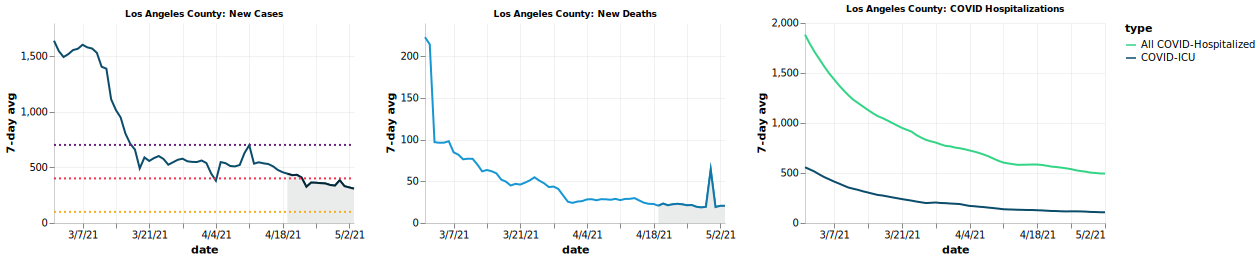

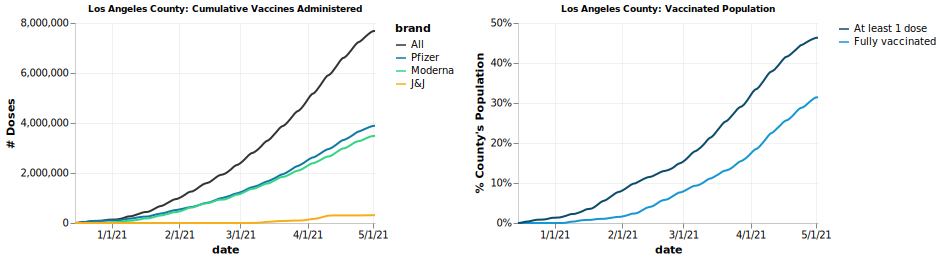

#### Riverside, CA

As of 5/3/21, there were **298,572** total cases and **4,574** total deaths. <br>In the past week, new cases grew by **-16.3%**; new deaths went from **4.4** to **2.1**. <br>New cases are **0.5x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>.<br>In the past week, the doubling time went from **3,251 days** to **3,965 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **-5.3%**.; COVID ICU hospitalizations grew by **0.6%**. 

**1,504,259** cumulative doses have been administered (82,618 doses administered in the past week). Already, **36.9%** of the county has received at least 1 dose and **25.7%** is fully vaccinated.

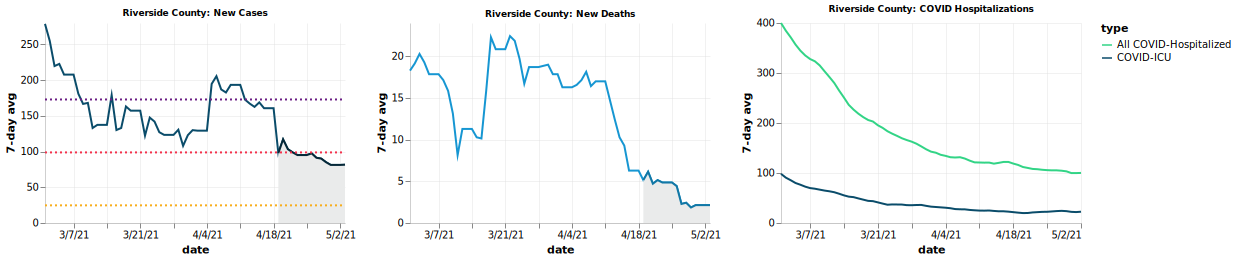

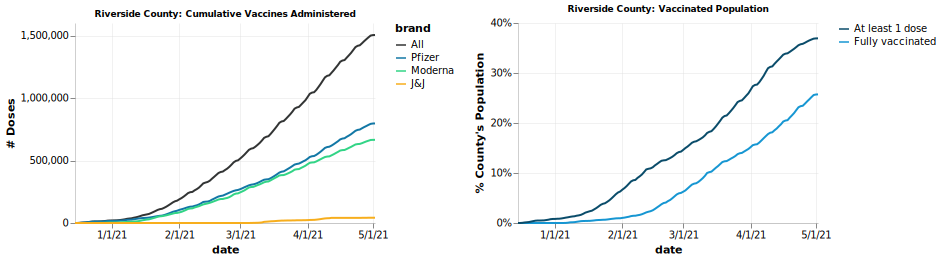

In [4]:
for c in ca_counties:
    id_anchor = c.replace(" - ", "-").replace(" ", "-")

    display(HTML(f"<a id={id_anchor}></a>"))
    plot_charts(jhu, hospitalizations, vaccinations, c)
    display(HTML(
        "<br>"
        "<a href=#counties_by_region>Return to top</a><br>"
    ))

<a id=summary></a>

## Summary of CA Counties

In [ ]:
ca_boundary = gpd.read_file("../data/ca_counties_boundary.geojson")

def grab_map_stats(df):
    # Let's grab the last available date for each county
    df = (df.sort_values(["county", "fips", "date2"], 
                         ascending = [True, True, False])
          .drop_duplicates(subset = ["county", "fips"], keep = "first")
          .reset_index(drop=True)
         )
    
    # Calculate its severity metric
    df = df.assign(
        severity = (df.cases_avg7 / df.tier3_case_cutoff).round(1)
    )
    
    # Make gdf
    gdf = pd.merge(ca_boundary, df, 
                   on = ["fips", "county"], how = "left", validate = "1:1")
    gdf = gdf.assign(
        cases_avg7 = gdf.cases_avg7.round(1),
        deaths_avg7 = gdf.deaths_avg7.round(1),
    )
    return gdf

gdf = grab_map_stats(jhu)

#### Severity by County
Severity measured as proportion relative to Tier 4 (widespread) threshold.
<br>*1 = at Tier 4 threshold*
<br>*2 = 2x higher than Tier 4 threshold*

In [ ]:
MAX_SEVERITY = gdf.severity.max()

light_gray = make_charts.light_gray

#https://stackoverflow.com/questions/47846744/create-an-asymmetric-colormap
# If severity = 1 when case_rate = 7 per 100k
# If severity = x when case_rate = 4 per 100k
# If severity = y when case_rate = 1 per 100k
# x = 4/7; y = 1/7
# Note: CA reopening guidelines have diff thresholds based on how many vaccines are administered...
# We don't have vaccine info, so ignore, use original cut-offs

colormap_cutoff = [
    (1/7), (4/7), 1, 2.5, 5
]

colorscale = branca.colormap.StepColormap(
                colors=["#D0E700", "#F7AE1D", "#F77889", 
                        "#D59CE8", "#B249D4", "#6B1F84", # purples
                       ], 
                index=colormap_cutoff,
                vmin=0, vmax=MAX_SEVERITY,
)

display(Markdown("Severity Scale"))
display(colorscale)

In [ ]:
# https://stackoverflow.com/questions/64792041/white-gap-between-python-folium-map-and-jupyter-notebook-cell
# Folium examples: https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Colormaps.ipynb
from branca.element import Figure
fig = Figure(width=550, height=400)

#https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJsonPopupAndTooltip.ipynb
m = folium.Map(location=[36.2, -119.1], tiles='cartodbpositron', 
               zoom_start=5.25, width=550,height=400)
 
popup = GeoJsonPopup(
    fields=["county", "severity"],
    aliases=["County", "Severity"],
    localize=True,
    labels=True,
    style=f"background-color: light_gray;",
    max_width = 100,
)

tooltip = GeoJsonTooltip(
    fields=["county", 
            "severity", 
            "new_cases",
            "cases_avg7",
            "new_deaths", 
            "deaths_avg7",
            "cases", 
            "deaths",
           ],
    aliases=["County:", 
             "<b>Severity:</b>", 
             "New Cases Yesterday:",
             "New Cases (7-day rolling avg):",
             "New Deaths Yesterday:", 
             "New Deaths (7-day rolling avg):",
             "Cumulative Cases", 
             "Cumulative Deaths",
            ],
    localize=True,
    sticky=False,
    labels=True,
    style=f"""
        background-color: {light_gray};
        border: 0px #FFFFFF;
        border-radius: 0px;
        box-shadow: 0px;
        font-size: 11px;
    """,
    max_width=250,
)

#https://medium.com/analytics-vidhya/create-and-visualize-choropleth-map-with-folium-269d3fd12fa0
g = folium.GeoJson(
    gdf.drop(columns = ["date", "date2"]),
    style_function=lambda x: {
        "fillColor": colorscale(x["properties"]["severity"])
        if x["properties"]["severity"] is not None
        else f"{light_gray}",
        "color": "#FFFFFF",
        "fillOpacity": 0.8,
        "weight": 0.2,
    },
    tooltip=tooltip,
    popup=popup,
).add_to(m)


fig.add_child(m)
fig

In [ ]:
table = (gdf[gdf.severity.notna()]
         [["county", "severity"]]
         .sort_values("severity", ascending = False)
         .reset_index(drop=True)
        )

df1_styler = (table.iloc[:14].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 1')
              .hide_index()
             )
df2_styler = (table.iloc[15:29].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 2')
              .hide_index()
             )
df3_styler = (table.iloc[30:].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 2')
              .hide_index()
             )

display(Markdown("#### Counties (in order of decreasing severity)"))
display_html(df1_styler._repr_html_() + 
             df2_styler._repr_html_() + 
             df3_styler._repr_html_(), raw=True)
             

[Return to top](#counties_by_region)